# lya_fields.py

In [16]:
import numpy as np
import tensorflow as tf

# local modules
import grid
import lya_fields
import snapshot
from spectrum import gmlt_spec_od_grid

# define dataset paths
ds_path_rhob = "/native_fields/baryon_density"
ds_path_temp = "/native_fields/temperature"
ds_path_vx   = "/native_fields/velocity_x"
ds_path_vy   = "/native_fields/velocity_y"
ds_path_vz   = "/native_fields/velocity_z"

ds_path_nhi      = "/derived_fields/HI_number_density"
ds_path_tau_real = "/derived_fields/tau_real"
ds_path_tau_red  = "/derived_fields/tau_red"

filename = "../../../../../cscratch1/sd/jupiter/sim2_z3_FGPA_cgs.h5"
snap = snapshot.Snapshot(filename)

## Compute $n_\text{H I}$ (1024^2 grid)

In [ ]:
# subsection shape
shape = [1, 1024, 1024]

rhob = snap.read_subfield(ds_path_rhob, shape)
temp = snap.read_subfield(ds_path_temp, shape)

In [34]:
# get the nhi grid
with tf.GradientTape(persistent=True) as tape:
    
#     tape.watch(rhob.field)
#     tape.watch(temp.field)

    nhi = lya_fields.set_nhi(snap, rhob, temp)

EOS duration: 6.198818683624268


In [35]:
print("nhi's shape:", tf.shape(nhi.field))
dn_dr = tape.gradient(nhi.field, rhob.field)
dn_dt = tape.gradient(nhi.field, temp.field)

nhi's shape: tf.Tensor([   1 1024 1024], shape=(3,), dtype=int32)


In [8]:
def print_minmax(t, name):
    '''
    Given a tensor t and its name, print t's minimum and maximum values.
    
    '''
    
    print(name + ' min:', np.amin(t))
    print(name + ' max:', np.amax(t))
    print('')

In [48]:
print_minmax(dn_dr, 'dn/dr')
print_minmax(dn_dt, 'dn/dt')

dn/dr min: 7.010278761870149e-16
dn/dr max: 2.9479211042723606e-10

dn/dt min: -1.2248301543284444e-19
dn/dt max: -4.053215596217278e-21



## Look at the $\frac{dn}{d\rho}$ and $\frac{dn}{dT}$ fields

In [21]:
import matplotlib as mpl
import matplotlib.pyplot as plt

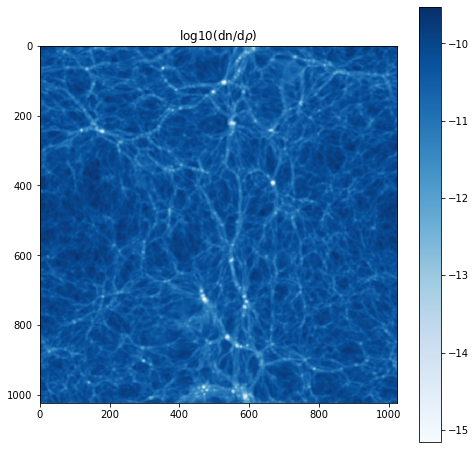

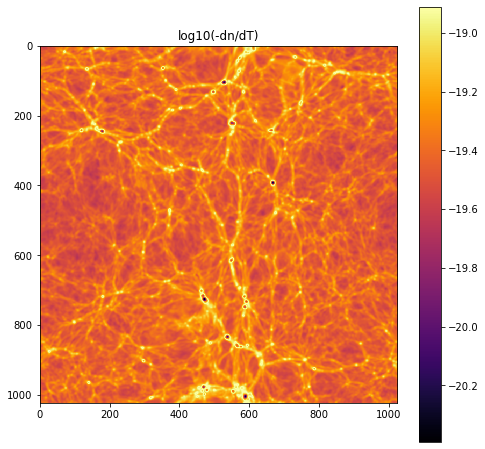

In [42]:
fig = plt.figure(figsize=(8,8))
plt.imshow(np.log10(dn_dr[0,:,:]), cmap='Blues')
plt.colorbar()
plt.title(r'log10(dn/d$\rho$)')
plt.show()

fig = plt.figure(figsize=(8,8))
plt.imshow(np.log10(-dn_dt[0,:,:]), cmap='inferno')
plt.colorbar()
plt.title('log10(-dn/dT)')
plt.show()

## Compute $\tau_\text{real}$ and $\tau_\text{red}$ (one skewer)

In [45]:
# subsection shape
shape = [1, 1, 10]

rhob = snap.read_subfield(ds_path_rhob, shape)
temp = snap.read_subfield(ds_path_temp, shape)

# get the tau grids
with tf.GradientTape(persistent=True) as tape:
#     tape.watch(rhob.field)
#     tape.watch(temp.field)

    # number density
    nhi = lya_fields.set_nhi(snap, rhob, temp)
    
    # real-space tau
    vpara = grid.Grid(tf.zeros(rhob.shape, dtype='float64'), rhob.shape, rhob.size)
    tau_real = gmlt_spec_od_grid(snap.universe, snap.z, nhi.size,
            nhi.field, temp.field, vpara.field, nhi.field.shape[2])

    # redshift-space tau
    vpara = snap.read_subfield(ds_path_vz, shape)
    tau_red = gmlt_spec_od_grid(snap.universe, snap.z, nhi.size,
            nhi.field, temp.field, vpara.field, nhi.field.shape[2])

EOS duration: 7.0143890380859375
tau duration: 0.31199145317077637
tau duration: 0.24521684646606445


## tape.gradient vs. tape.jacobian

The $i$th element in `tape.gradient(tau_real.field, rhob.field)` is the gradient of the sum of all $\tau$s with respect to $\rho_i$, which isn't what we want.

To get $\frac{\partial \tau_i}{\partial x_j}$ for every pair $i,j$, we need the Jacobian.

## Look at the 4 Jacobians

In [63]:
dtreal_dr_j = tape.jacobian(tau_real.field, rhob.field)
# dtreal_dt_j = tape.jacobian(tau_real.field, temp.field)

# dtred_dr_j = tape.jacobian(tau_red.field, rhob.field)
# dtred_dt_j = tape.jacobian(tau_red.field, temp.field)

Error: interp.dfitpack.bispeu doesn't work
<class 'TypeError'>


TypeError: in user code:

    /global/homes/j/jupiter/.conda/envs/lya-tf/lib/python3.7/site-packages/tensorflow/python/ops/parallel_for/control_flow_ops.py:188 f  *
        iters,
    /global/homes/j/jupiter/.conda/envs/lya-tf/lib/python3.7/site-packages/tensorflow/python/ops/parallel_for/control_flow_ops.py:248 _pfor_impl  **
        loop_fn_outputs = loop_fn(loop_var)
    /global/homes/j/jupiter/.conda/envs/lya-tf/lib/python3.7/site-packages/tensorflow/python/eager/backprop.py:1179 loop_fn
        unconnected_gradients=unconnected_gradients)
    /global/homes/j/jupiter/.conda/envs/lya-tf/lib/python3.7/site-packages/tensorflow/python/eager/backprop.py:1086 gradient
        unconnected_gradients=unconnected_gradients)
    /global/homes/j/jupiter/.conda/envs/lya-tf/lib/python3.7/site-packages/tensorflow/python/eager/imperative_grad.py:77 imperative_grad
        compat.as_str(unconnected_gradients.value))
    /global/homes/j/jupiter/.conda/envs/lya-tf/lib/python3.7/site-packages/tensorflow/python/ops/custom_gradient.py:473 actual_grad_fn
        input_grads = grad_fn(*result_grads)
    /global/u2/j/jupiter/lya-tf/lya_fields/lya_fields.py:180 grad
        flatten(log10_rhob), flatten(log10_temp))[0]

    TypeError: __array__() takes 1 positional argument but 2 were given


In [ ]:
# this returns the same error as above
dtreal_dn_j = tape.jacobian(tau_real.field, nhi.field)
print(dtreal_dn)

In [55]:
dtreal_dr = tape.gradient(tau_real.field, rhob.field)
print(dtreal_dr)

interp.dfitpack.bispeu works!
tf.Tensor(
[[[0.86485571 0.85401464 0.84764359 0.86511012 0.91840627 1.01609947
   1.15752664 1.32944003 1.49078351 1.58507927]]], shape=(1, 1, 10), dtype=float64)


In [5]:
# dtreal_dr = tape.gradient(tau_real.field, rhob.field)
# dtreal_dt = tape.gradient(tau_real.field, temp.field)

# dtred_dr = tape.gradient(tau_red.field, rhob.field)
# dtred_dt = tape.gradient(tau_red.field, temp.field)

# print_minmax(dtreal_dr, 'dtreal/dr')
# print_minmax(dtreal_dt, 'dtreal/dt')

# print_minmax(dtred_dr, 'dtred/dr')
# print_minmax(dtred_dt, 'dtred/dt')

### Look at the 4 $\frac{d\Sigma \tau}{dx_i}$ fields (tape.gradient)

In [ ]:
figsize=(16,4)

section = slice(0,80)

vmin_r = -0.5
vmax_r = 0.5
vmin_t = 2e-10
vmax_t = 7e-10

fig = plt.figure(figsize=figsize)
plt.imshow(np.log10(dtreal_dr[0, :, section]), cmap='Blues', vmin=vmin_r, vmax=vmax_r)
plt.colorbar()
plt.title(r'log10($d\tau_{real} / d\rho$) (left)')
plt.show()

fig = plt.figure(figsize=figsize)
plt.imshow(np.log10(dtred_dr[0, :, section]), cmap='Blues', vmin=vmin_r, vmax=vmax_r)
plt.colorbar()
plt.title(r'log10($d\tau_{red} / d\rho$) (left)')
plt.show()

fig = plt.figure(figsize=figsize)
plt.imshow(-dtreal_dt[0, :, section], cmap='inferno', vmin=vmin_t, vmax=vmax_t)
plt.colorbar()
plt.title(r'-$d\tau_{real} / dT$ (left)')
plt.show()

fig = plt.figure(figsize=figsize)
plt.imshow(-dtred_dt[0, :, section], cmap='inferno', vmin=vmin_t, vmax=vmax_t)
plt.colorbar()
plt.title(r'-$d\tau_{red} / dT$ (left)')
plt.show()